In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from locnetwork import Network

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


(1000,)
(1000,)
(10,)
(10,)


Text(0.5, 0, 'Time (s)')

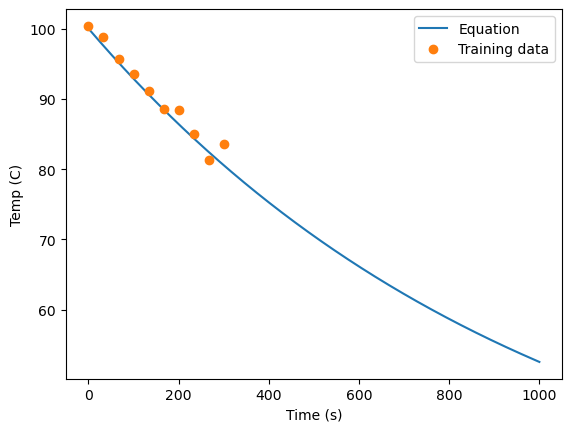

In [51]:
# before we can train our model, we need to generate the data
# to train it on (training data)

# note, for comparison, we will also generate the true data and
# plot it too

Tenv = 25 #temp of environment
T0 = 100 #initial temperature
k = 0.001 #arbitrary start point for cooling const.
time = np.linspace(0,1000,1000)
np.random.seed()

def true_sol(t):
    return Tenv + (T0 - Tenv)*np.exp(-k*t)

temp = true_sol(time)

t = np.linspace(0,300,10) # for taining data, only up to 300 with step 10
T = true_sol(t) + 2*np.random.randn(10)


print(np.shape(time))
print(np.shape(temp))
print(np.shape(t))
print(np.shape(T))


plt.plot(time, temp)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temp (C)')
plt.xlabel('Time (s)')

In [52]:
from torch.autograd import grad

def physics_loss(model: torch.nn.Module):
    t = torch.linspace(0,1000,steps=1000).view(-1,1).requires_grad_(True).to(torch.float32)
    T = model(t)
    dT = grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]  #we need [0] because the output of grad
                                                                            #is a tuple, 1000 rows, 1 element per row
    pde = k*(Tenv - T) - dT  #predicted pde vals (y_hat)

    return torch.mean(pde**2).to(torch.float32) #note this is the MSE Loss

Epoch: 0/20000, loss: 8012.34
Epoch: 2000/20000, loss: 4151.72
Epoch: 4000/20000, loss: 3305.85
Epoch: 6000/20000, loss: 316.70
Epoch: 8000/20000, loss: 12.07
Epoch: 10000/20000, loss: 7.56
Epoch: 12000/20000, loss: 4.26
Epoch: 14000/20000, loss: 2.68
Epoch: 16000/20000, loss: 2.45
Epoch: 18000/20000, loss: 2.56


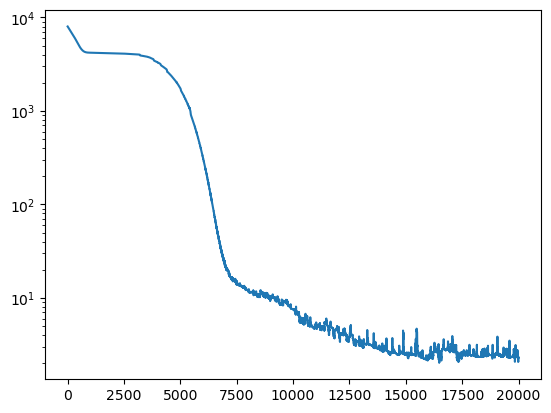

In [53]:
# now to see how the loss changes over time

network = Network(input_dim=1,output_dim=1,loss2=physics_loss,epochs=20000,loss2_weight=5000,lr=1e-5)

losses = network.fit(t,T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

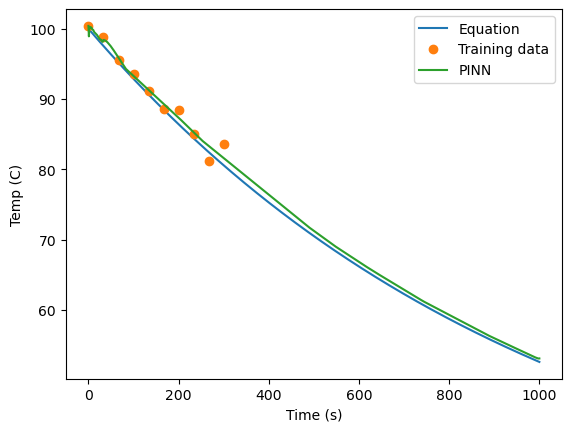

In [54]:
predictions = network.predict(time)

plt.plot(time, temp)
plt.plot(t, T, 'o')
plt.plot(time, predictions)
plt.legend(labels=['Equation', 'Training data', 'PINN'])
plt.ylabel('Temp (C)')
plt.xlabel('Time (s)')
